In [1]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')


In [2]:
from nn_utils import AE_big, AE_3D_100
from utils import plot_activations

In [3]:
torch.cuda.is_available()

True

In [4]:
fastai.torch_core.defaults.device = 'cuda'

In [5]:
# Load data
train = pd.read_pickle(BIN + '/../data/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle(BIN + '/../data/all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0])

train.head(10)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871
61832,6236.774414,30013.537109,-2.962712,0.091814
26867,17774.943359,205705.046875,2.472530,-1.299140
46232,4181.291992,20511.900391,-1.937396,-1.893408
44194,4537.854492,29095.220703,2.703056,-1.746550
59782,6769.761719,26334.353516,1.344461,-2.599911


In [6]:
train.dtypes

m      float64
pt     float64
phi    float64
eta    float64
dtype: object

In [7]:
train.shape

(111778, 4)

In [8]:
# Standardization
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

# converting the data values in numpy array to pytorch tensor and then loading it to TensorDataset
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float32), torch.tensor(train_y.values, dtype=torch.float32))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float32), torch.tensor(test_y.values, dtype=torch.float32))

[[-0.533282 -0.581905  1.087244 -0.071133]
 [-0.472437 -0.609328  0.573286  0.476957]
 [-0.498829 -0.570312 -0.622658  0.542203]
 [ 0.697978  1.98429   0.178861 -1.805121]
 ...
 [-0.418174 -0.539298 -0.443004  0.689991]
 [-0.55168  -0.561699 -1.210693 -1.605103]
 [-0.176735 -0.392414 -1.4821   -0.603219]
 [ 0.044597 -0.167061 -1.123961  0.377592]]


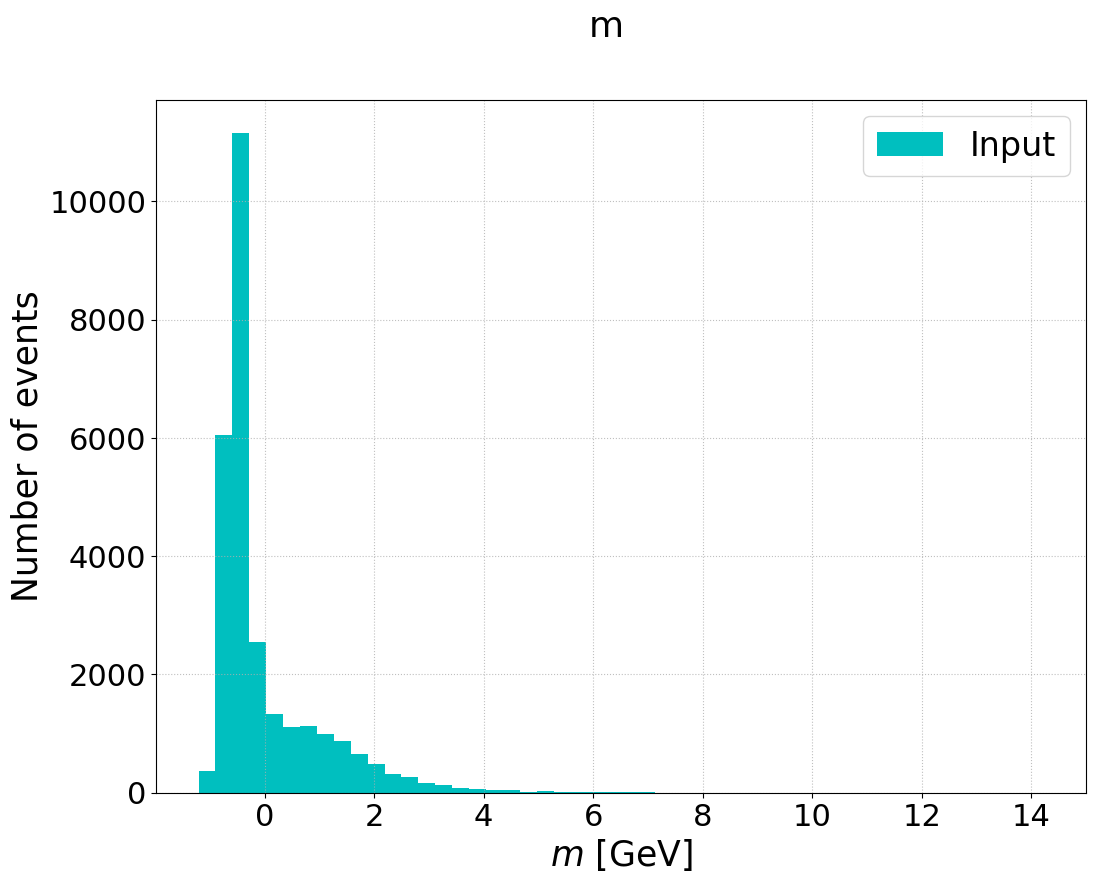

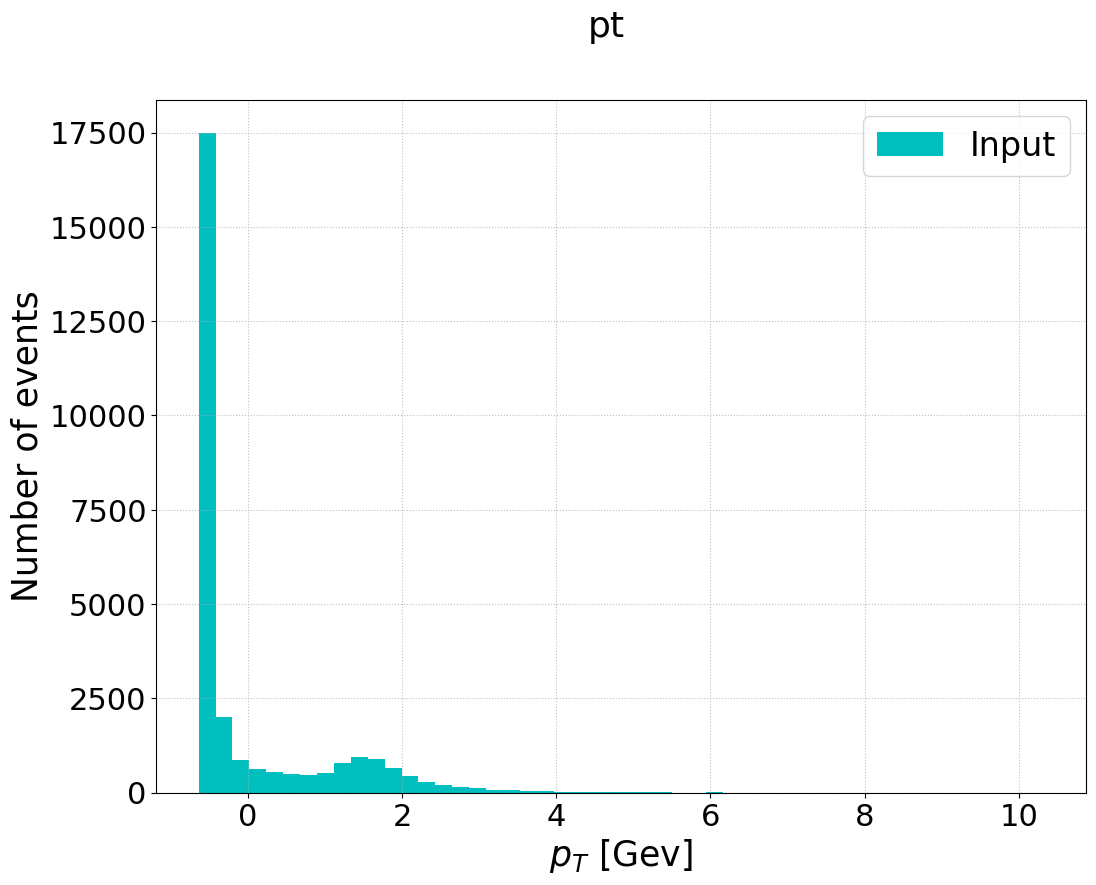

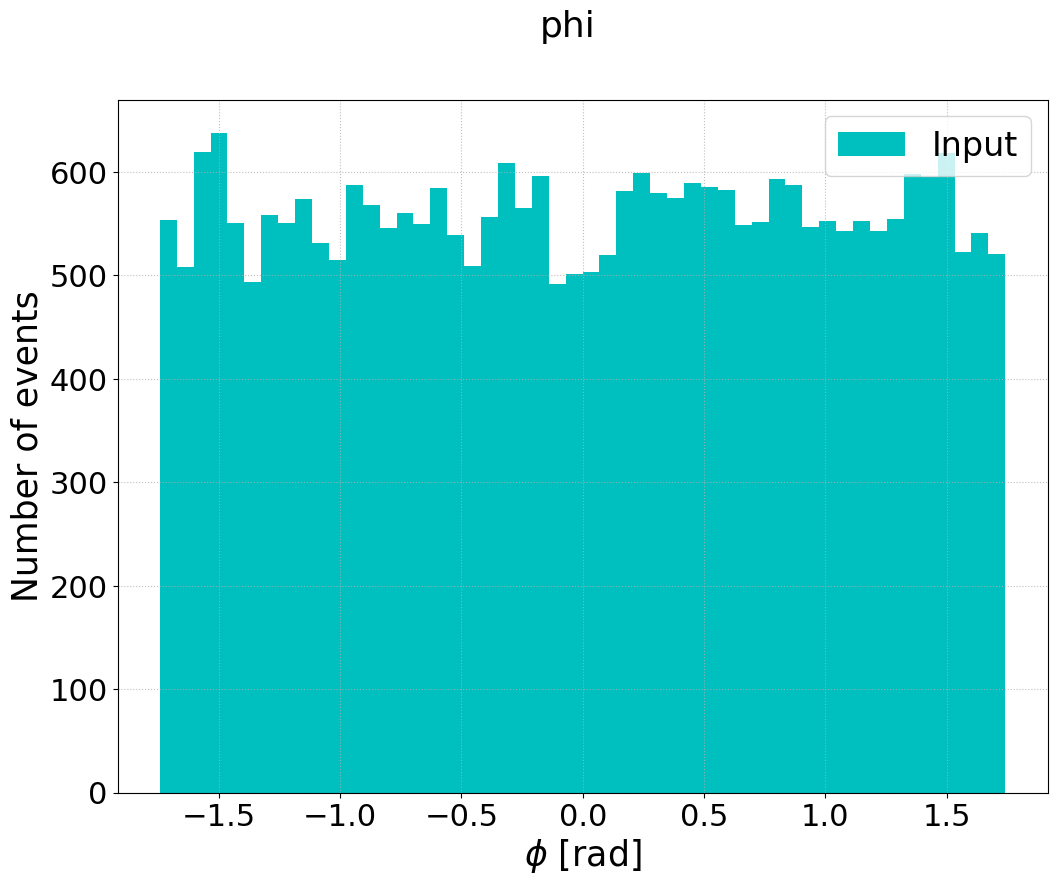

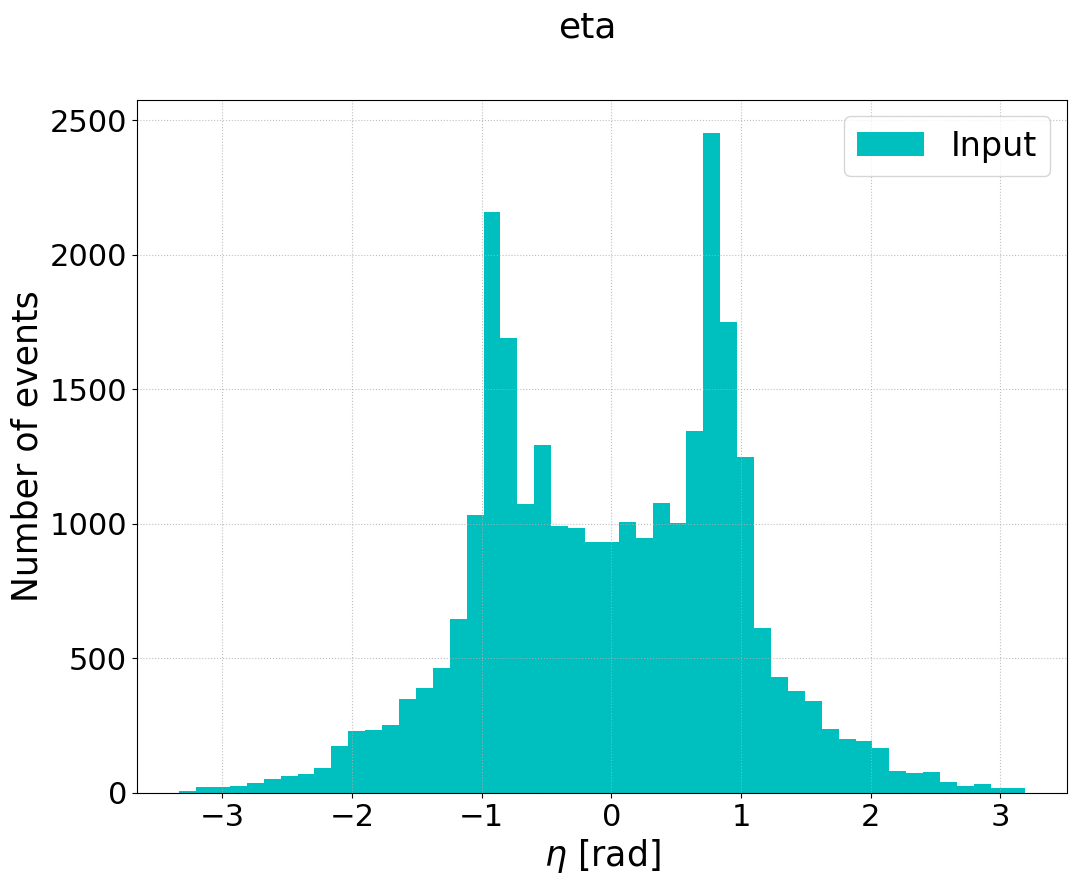

In [9]:
# Visualize data after Standardization

curr_save_folder = '../../data/after-norm/'
plt.close('all')
unit_list = ['[GeV]', '[Gev]', '[rad]', '[rad]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = test[idxs[0]:idxs[1]].values

print(data)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    plt.suptitle(test.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

In [10]:
train_ds[0]

(tensor([-0.6885, -0.6076,  0.8681,  0.7590]),
 tensor([-0.6885, -0.6076,  0.8681,  0.7590]))

In [11]:
def get_data(train_ds, valid_ds, bs):
    """
    Create and Return DataLoaders.
    
    Args: TensorDataset of training data and validation data
    Returns: tuple of dataloaders (training and validation)
    """
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [12]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [13]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [14]:
# Have a peak at one batch of data
db.one_batch()

(tensor([[ 0.9914,  1.9570,  0.0887,  1.6424],
         [-0.6181, -0.6099, -1.2394, -0.8407],
         [-0.6512, -0.6120,  0.9843,  0.6058],
         ...,
         [-0.7791, -0.4931, -0.9795, -1.6643],
         [ 1.4339,  1.5082,  0.4286,  1.2068],
         [-0.5359, -0.5999, -1.7110, -0.9274]]),
 tensor([[ 0.9914,  1.9570,  0.0887,  1.6424],
         [-0.6181, -0.6099, -1.2394, -0.8407],
         [-0.6512, -0.6120,  0.9843,  0.6058],
         ...,
         [-0.7791, -0.4931, -0.9795, -1.6643],
         [ 1.4339,  1.5082,  0.4286,  1.2068],
         [-0.5359, -0.5999, -1.7110, -0.9274]]))

In [15]:
# create an object of Neural Network we are going to use,
# .float() is used to tell model that we are dealing with float data
model = AE_3D_100().float()

In [16]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
    
# create an object of Lossfunction to evaluate model while training    
loss_func = nn.MSELoss().float()
#loss_func = RMSELoss()
#loss_func = my_loss_func

In [17]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [18]:
from fastai import train as tr
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


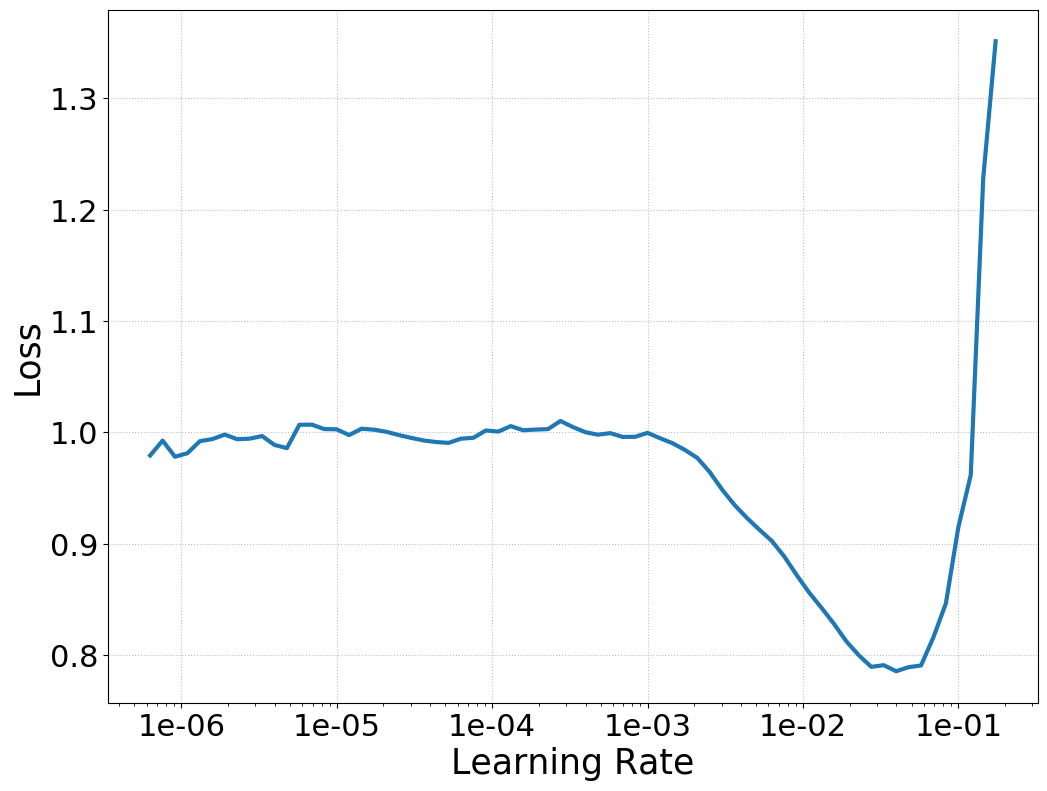

In [19]:
learn.recorder.plot()

In [20]:
lr = 1e-7
learn.fit(1, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.993976,1.022199,00:05


In [21]:
lr = 1e-4
learn.fit(10, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.075526,0.070989,00:04
1,0.038697,0.040556,00:04
2,0.034088,0.037146,00:04
3,0.034307,0.035903,00:04
4,0.032926,0.034477,00:04
5,0.030403,0.033463,00:04
6,0.032293,0.032722,00:04
7,0.029855,0.032228,00:04
8,0.029573,0.031808,00:04
9,0.030281,0.031608,00:04


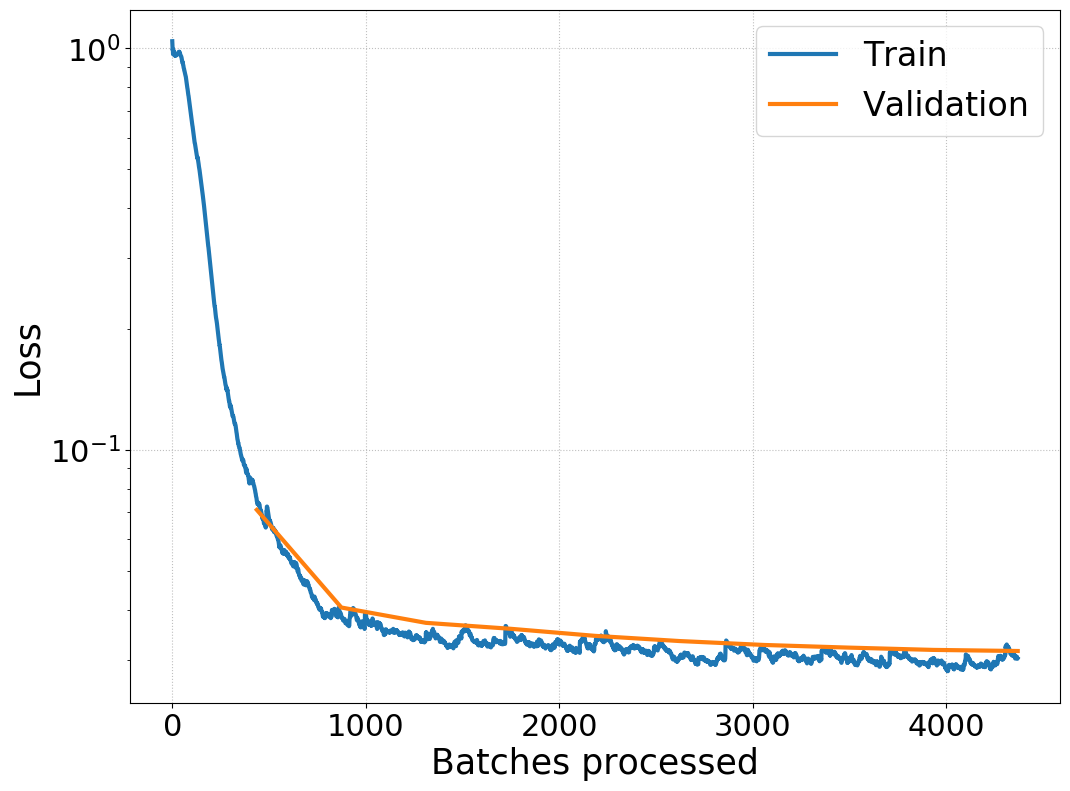

In [22]:
learn.recorder.plot_losses()
plt.yscale('log')

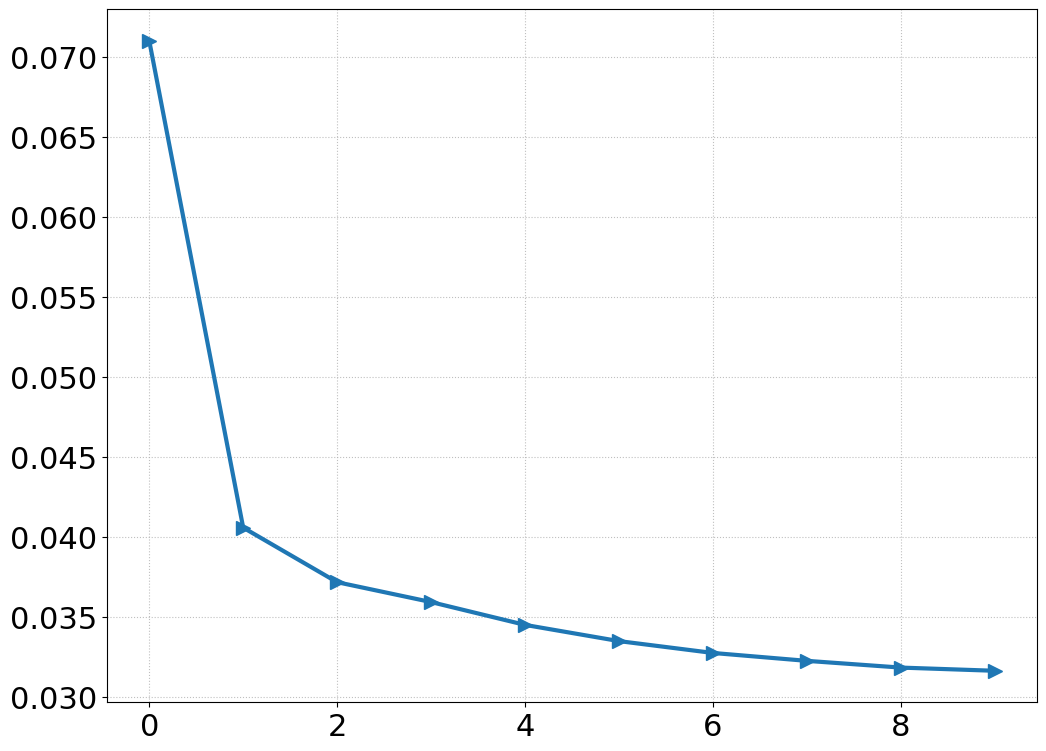

In [23]:
plt.plot(learn.recorder.val_losses, marker='>')

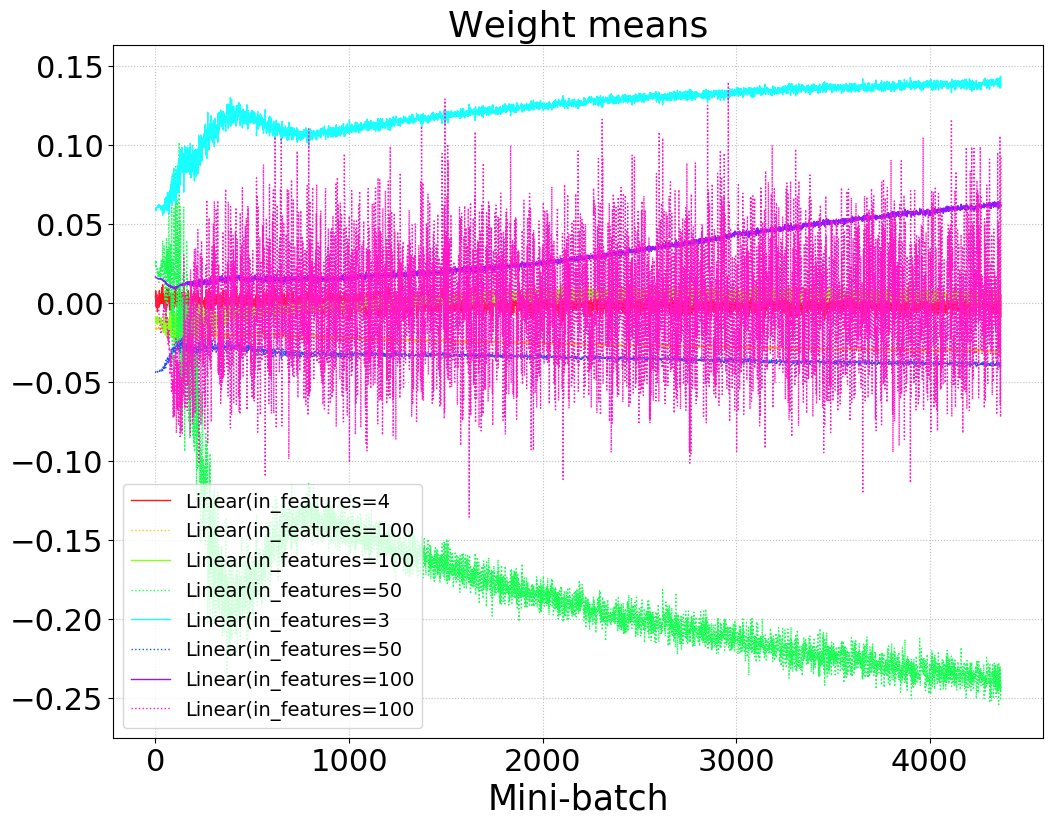

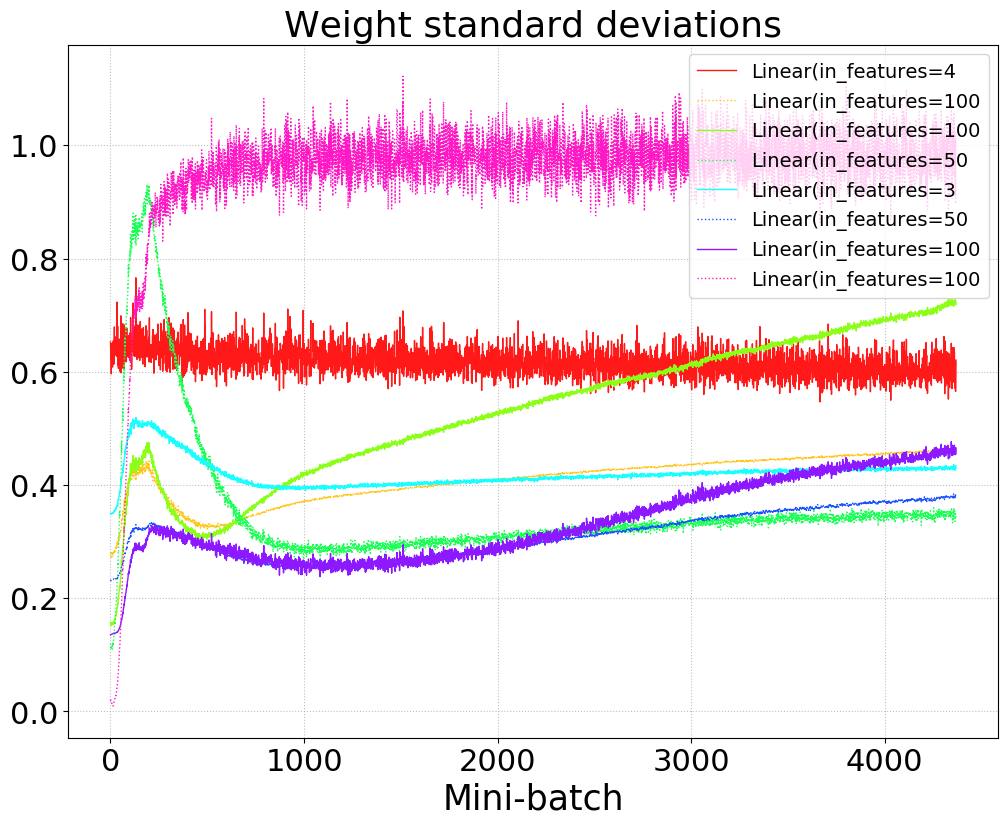

In [24]:
plot_activations(learn)

In [25]:
lr = 1e-2
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.036245,0.041556,00:04
1,0.031396,0.033814,00:04
2,0.033245,0.033871,00:04
3,0.029317,0.029422,00:04
4,0.031076,0.025974,00:04
5,0.031453,0.036361,00:04
6,0.028740,0.032760,00:04
7,0.024406,0.027455,00:04
8,0.026719,0.030605,00:04
9,0.024194,0.021505,00:04


In [26]:
learn.save('AE_3D_200_no1cycle_trainforever')

In [27]:
learn.load('AE_3D_200_no1cycle_trainforever')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7ff71a020550>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7ff71a020310>;

Test: None, model=AE_3D_100(
  (en1): Linear(in_features=4, out_features=100, bias=True)
  (en2): Linear(in_features=100, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=100, bias=True)
  (de4): Linear(in_features=100, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, 

/home/mr/anaconda3/envs/pytorch-dl/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


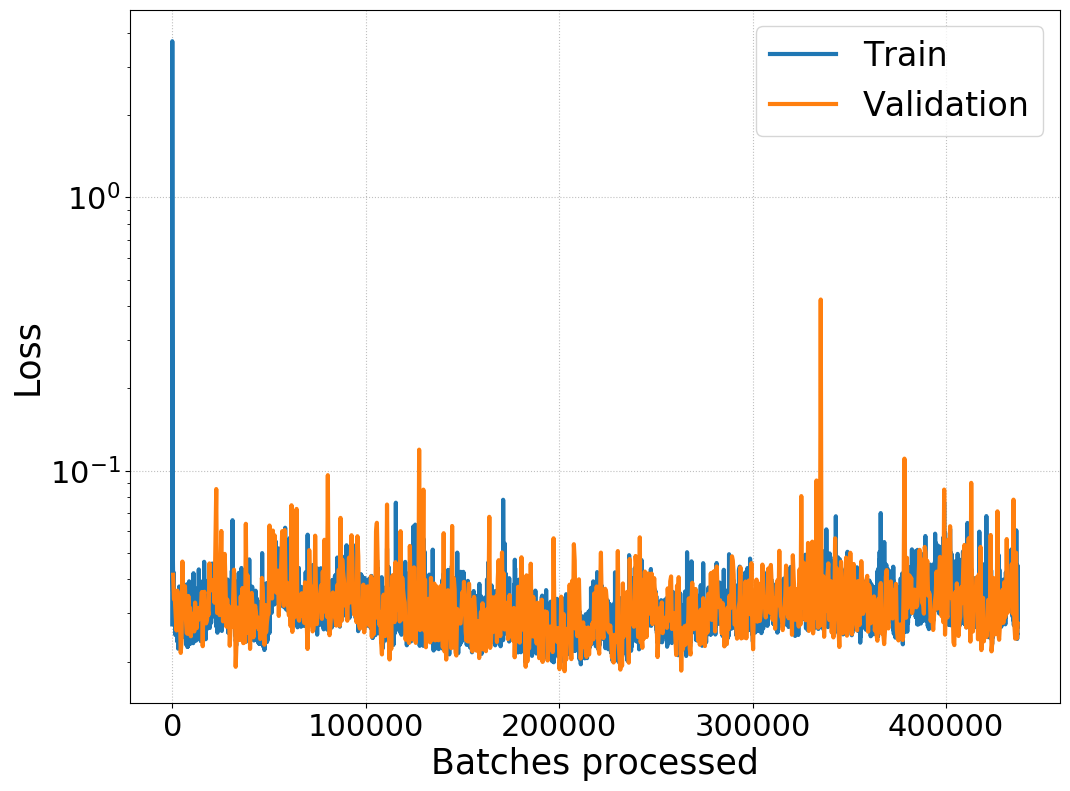

In [28]:
learn.recorder.plot_losses()
plt.yscale('log')

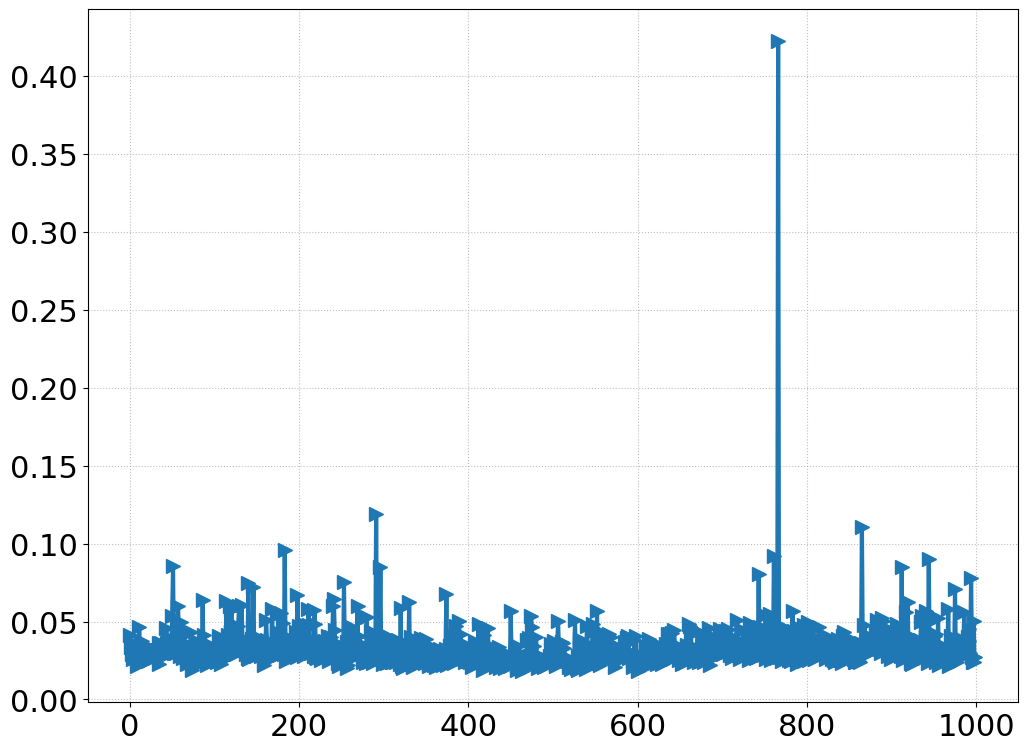

In [29]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [30]:
learn.validate()

[0.027503027]

In [31]:
curr_save_folder = 'trainforever_plots/'

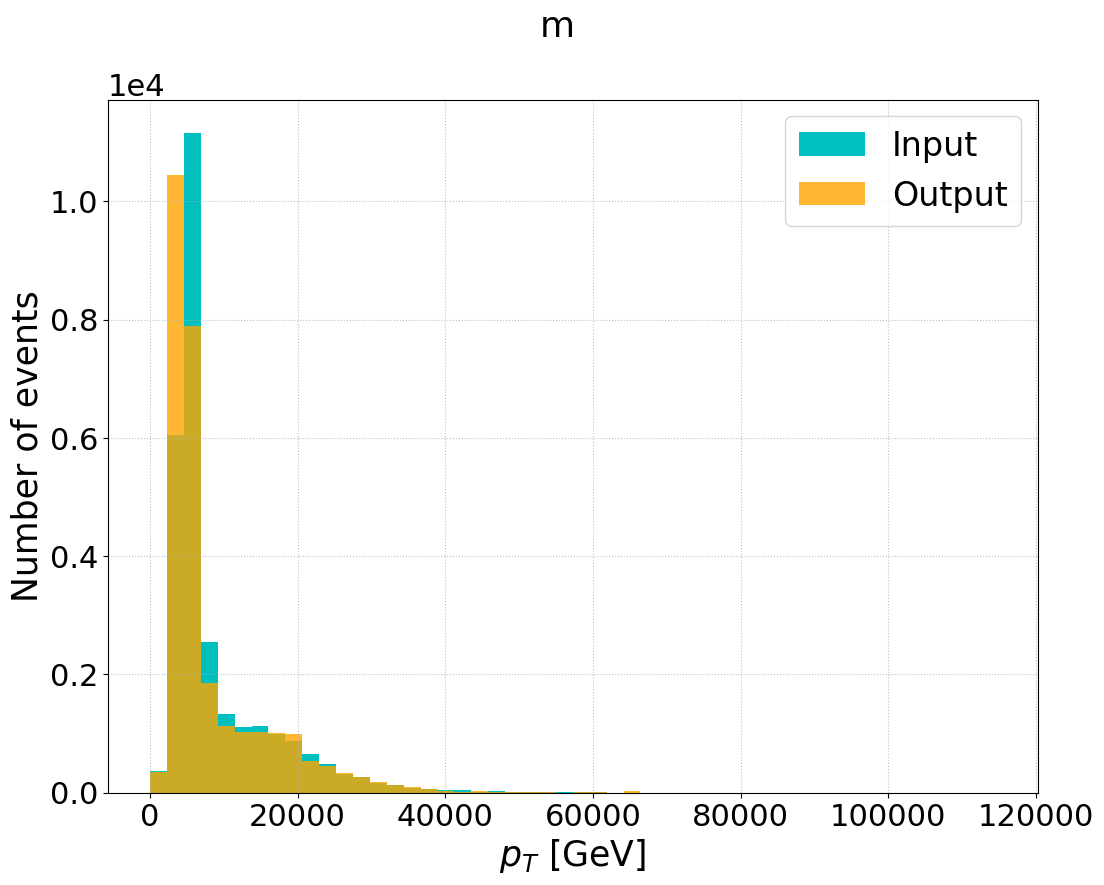

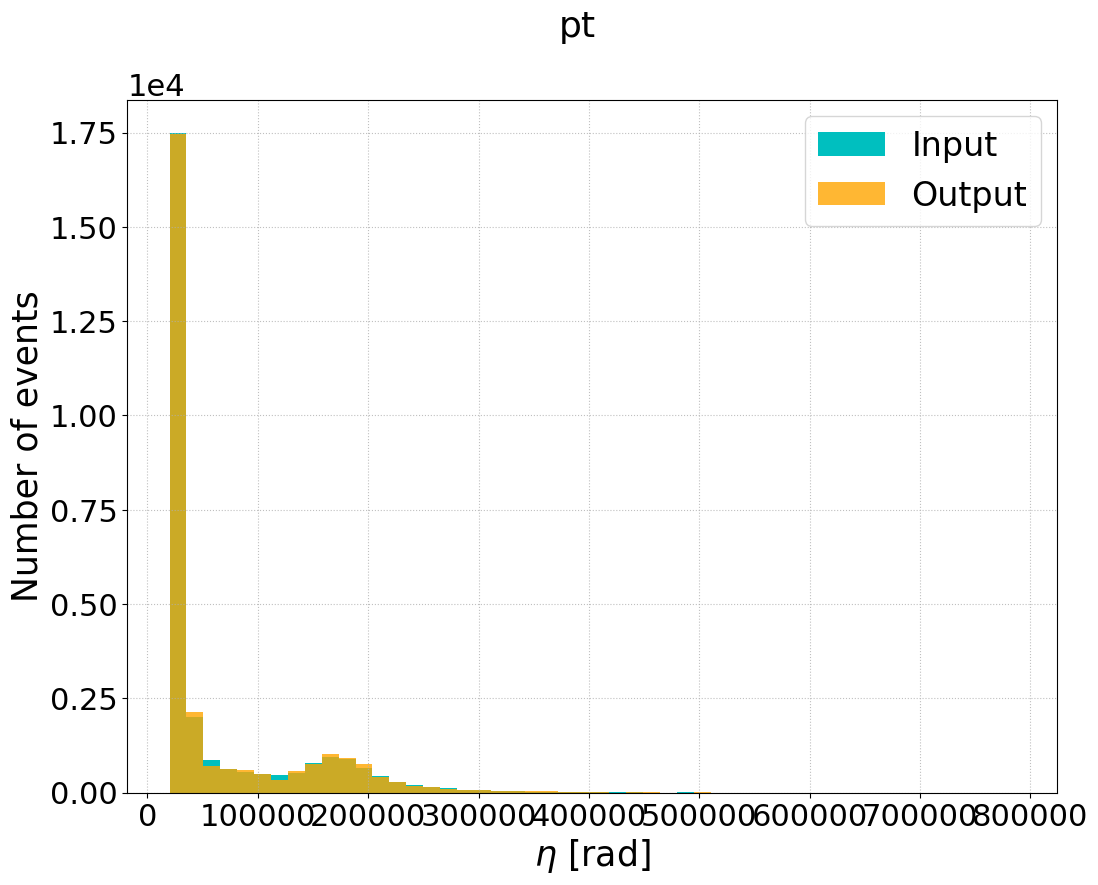

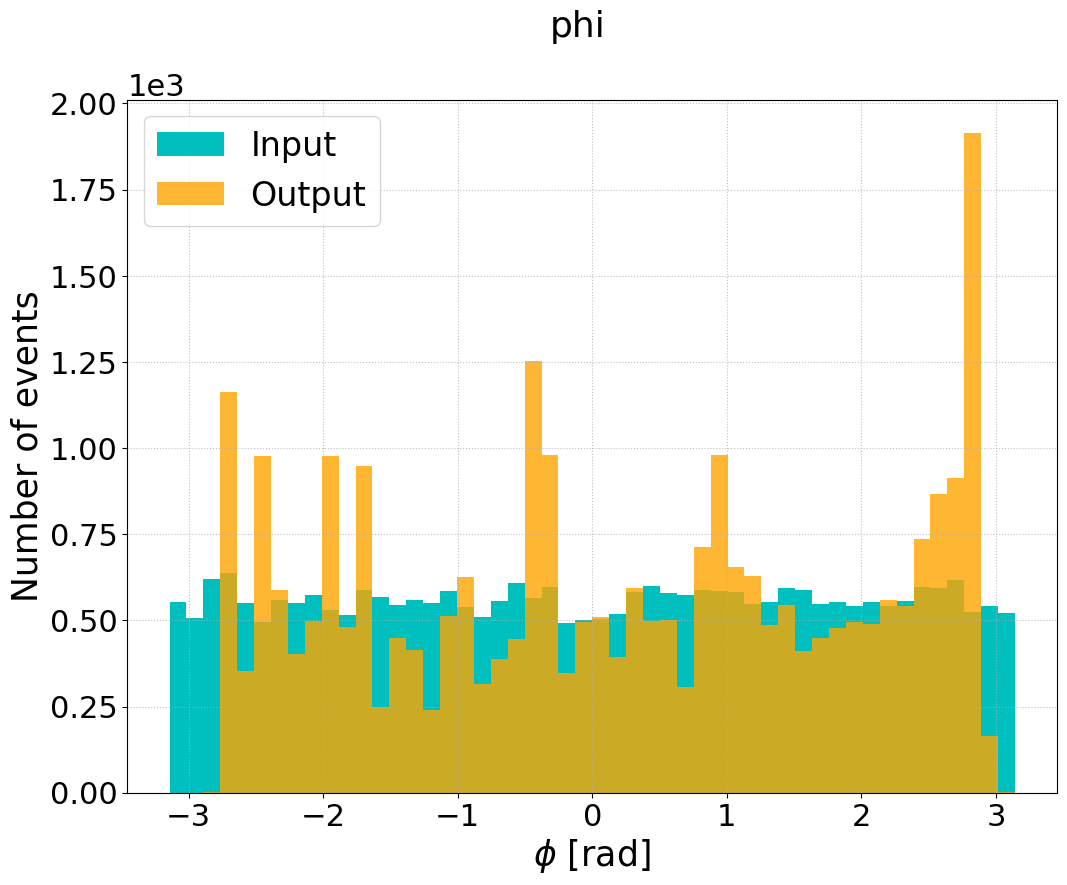

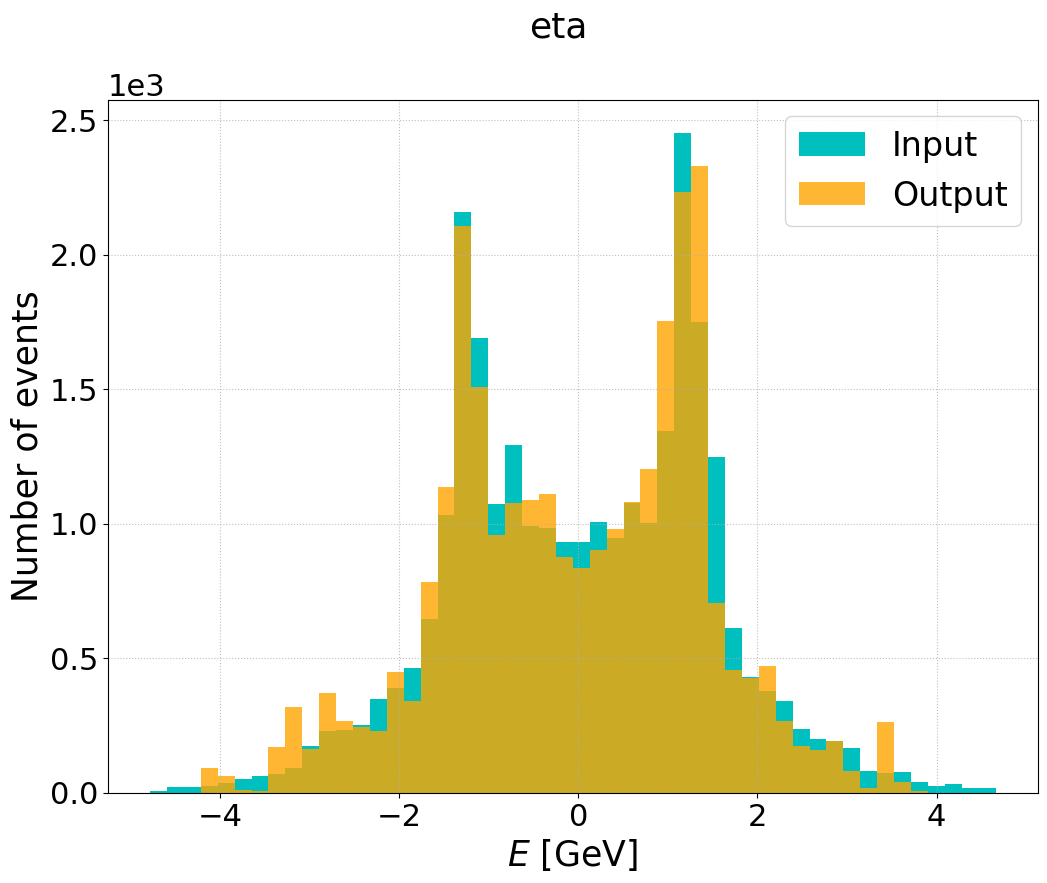

In [32]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values).float()
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

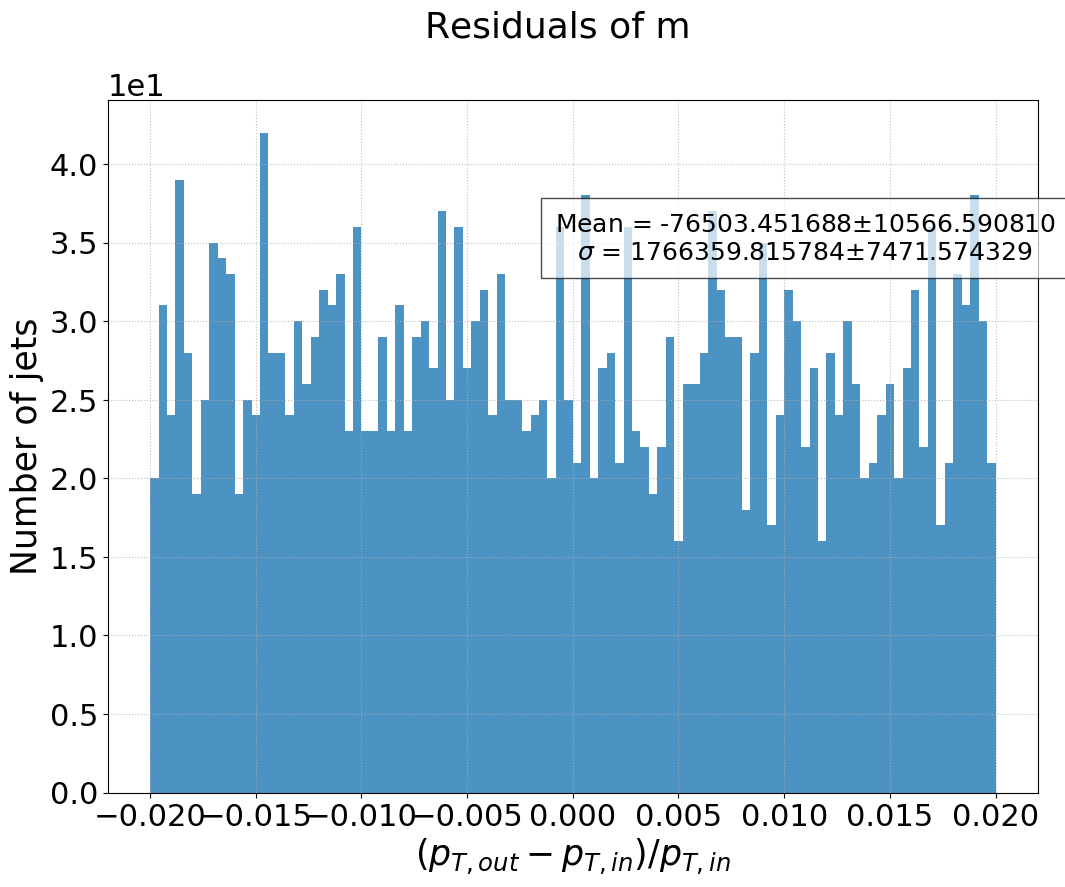

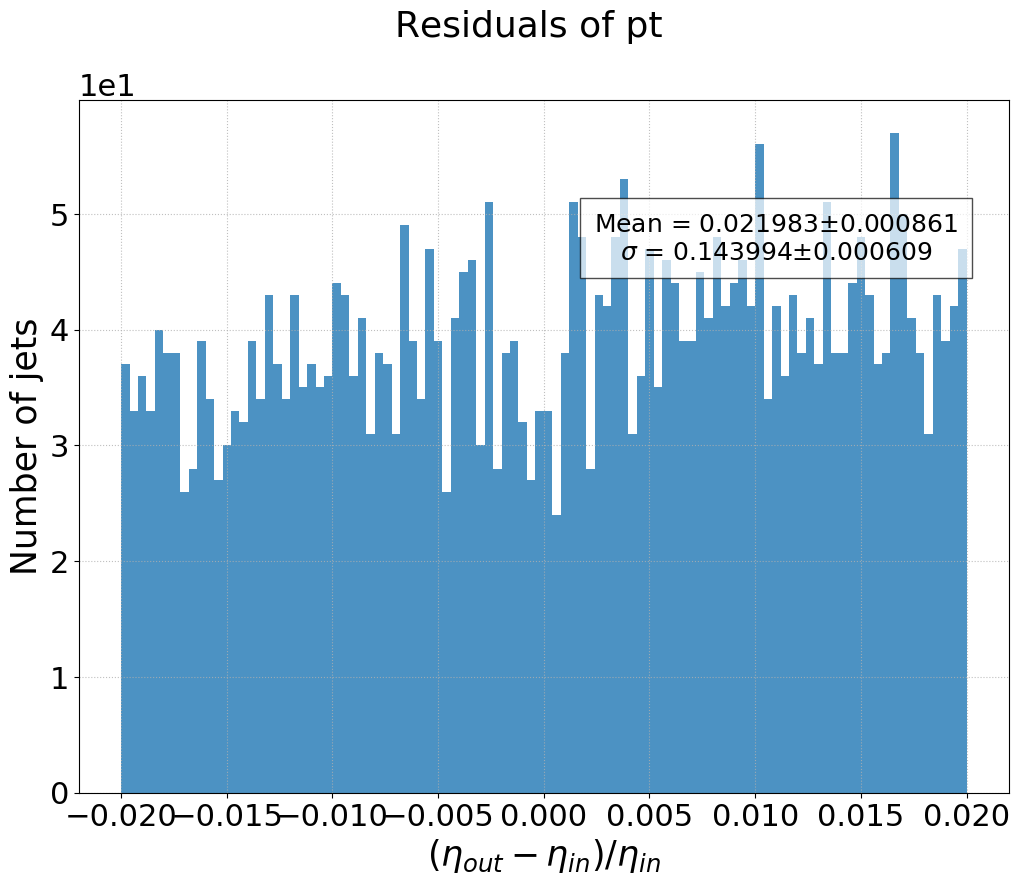

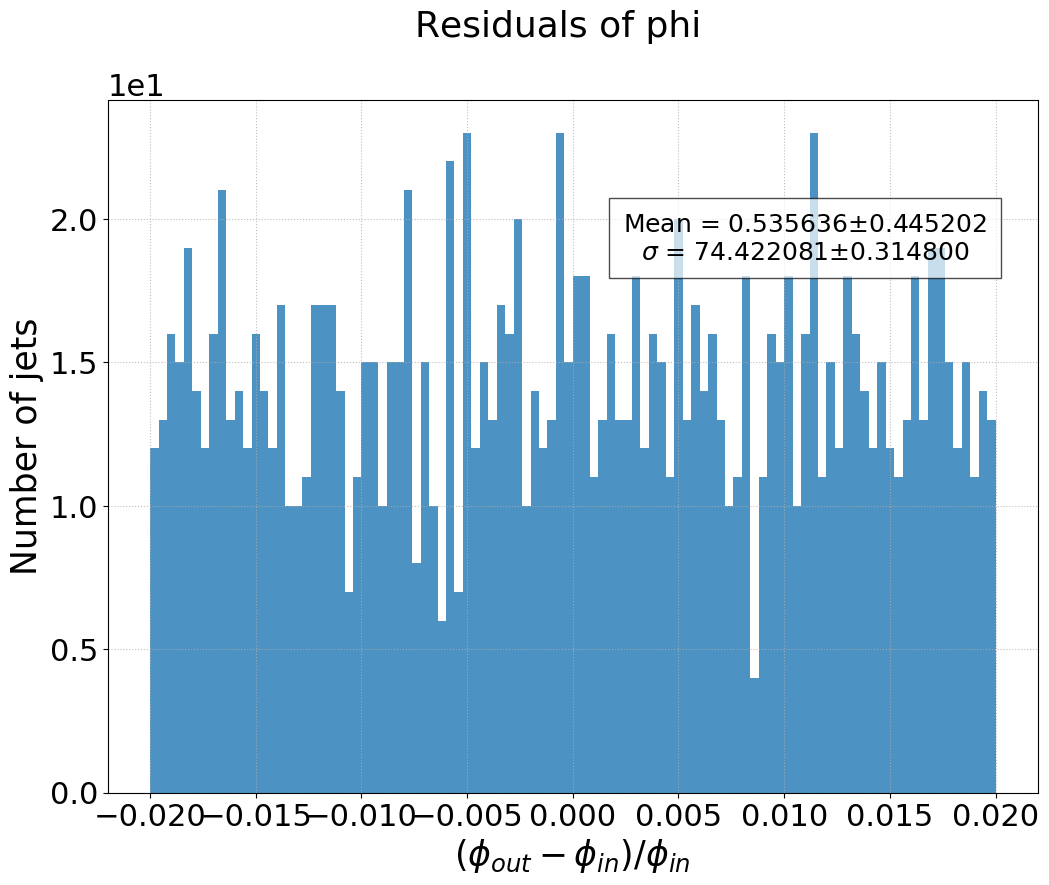

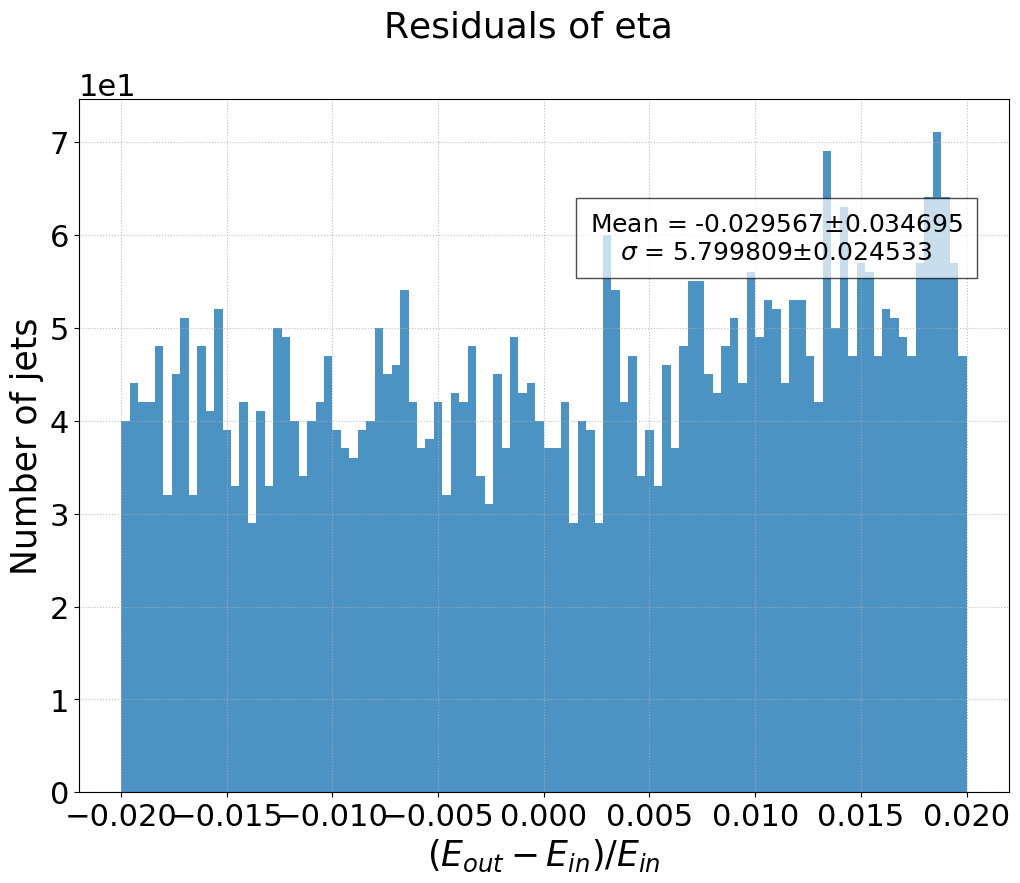

In [33]:
import utils
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-.02, .02)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

In [34]:
residuals[:,2].shape

(27945,)

In [35]:
test

,m,pt,phi,eta
85972,-0.533282,-0.581905,1.087244,-0.071133
38742,-0.472437,-0.609328,0.573286,0.476957
128711,-0.498829,-0.570312,-0.622658,0.542203
28751,0.697978,1.984290,0.178861,-1.805121
131358,-0.754120,-0.566174,0.218307,0.964189
...,...,...,...,...
133326,3.085881,2.459298,-1.655004,0.058346
12875,-0.418174,-0.539298,-0.443004,0.689991
111439,-0.551680,-0.561699,-1.210693,-1.605103
18479,-0.176735,-0.392414,-1.482100,-0.603219


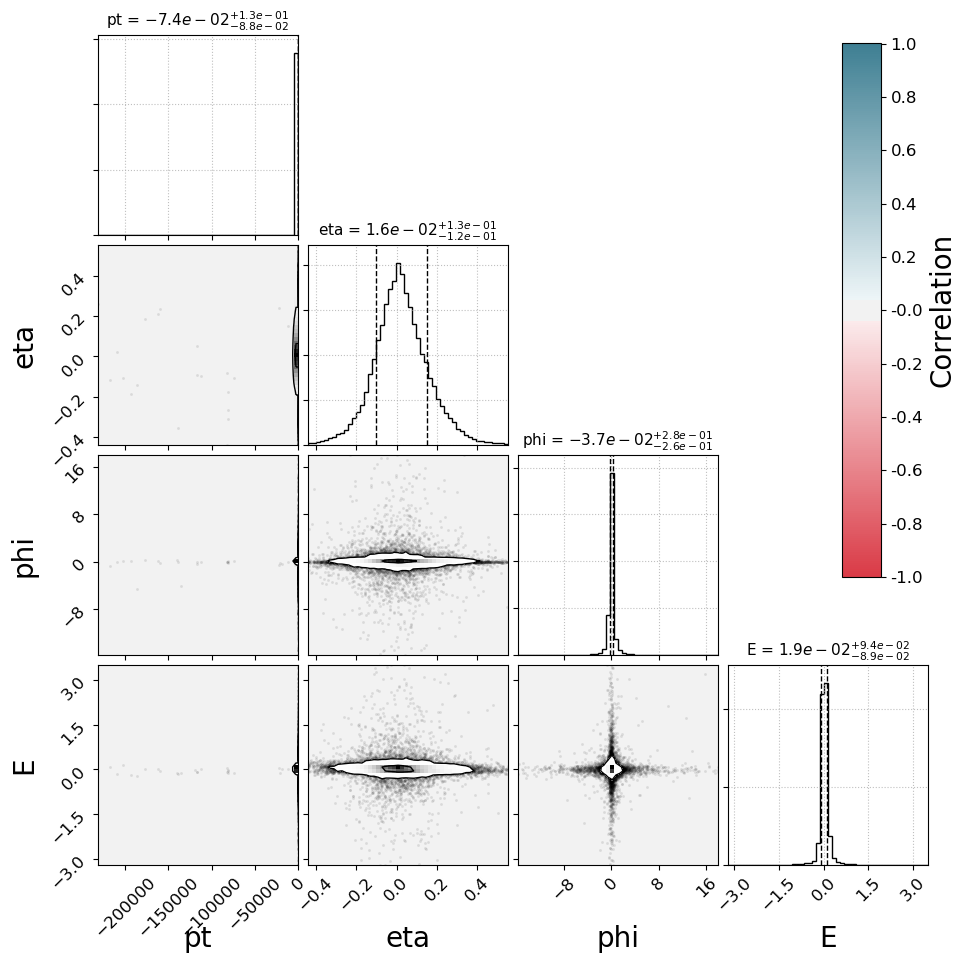

In [37]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
save = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['pt', 'eta', 'phi', 'E']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)

In [39]:
# print correlation matrix 
print(corr)

           pt       eta       phi         E
pt   1.000000  0.037750  0.000689 -0.000025
eta  0.037750  1.000000 -0.002057 -0.014473
phi  0.000689 -0.002057  1.000000 -0.000110
E   -0.000025 -0.014473 -0.000110  1.000000
